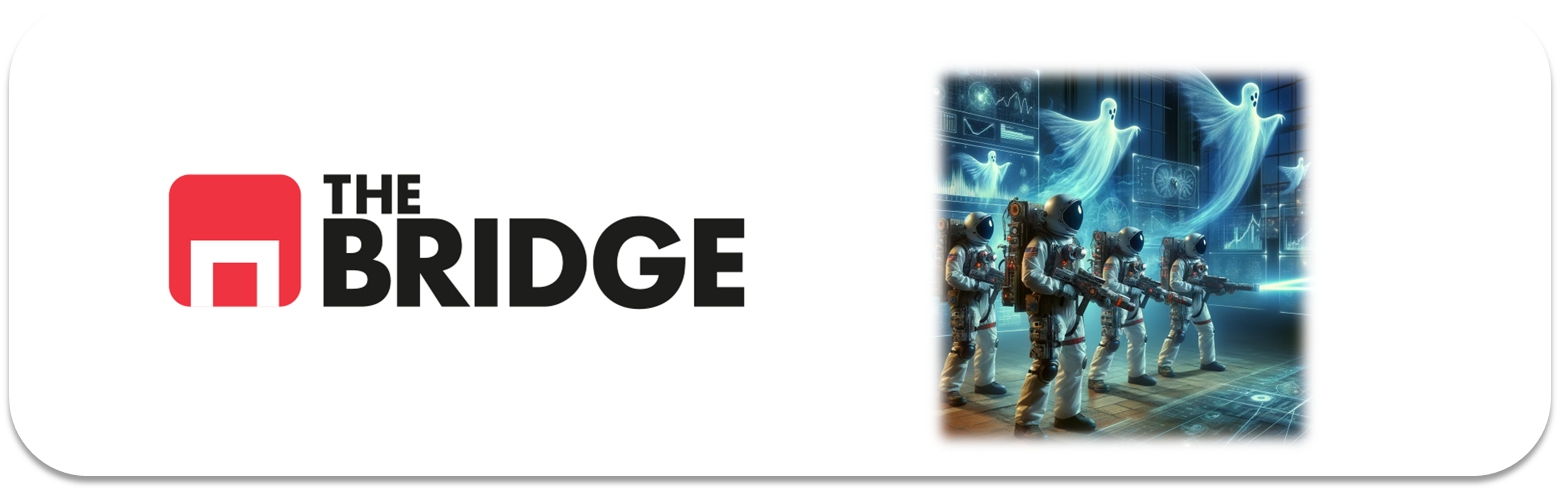

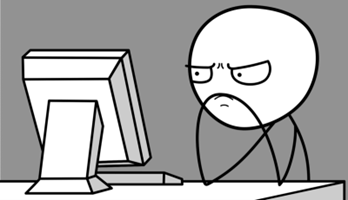

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [163]:
df = pd.read_csv("./data/AirPassengers.csv")
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [164]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date") # La fecha como índice, que si recuerdas de tiempos antiguos, nos ayudará en Pandas.

In [165]:
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

- Fechas: 01/01/1949 a 01/12/1960
- Periodicidad: mensual

### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

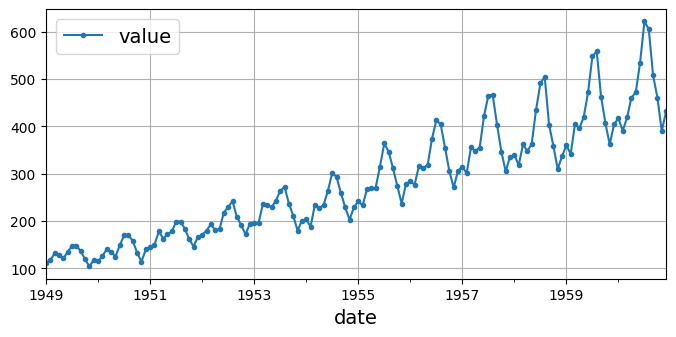

In [167]:
df["1949-01-01":"1960-12-01	"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

- Tiene una tendencia de crecimiento positiva
- También se observa estacionalidad, más marcada a partir del año 1954

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

In [168]:
# Prueba de Dickey-Fuller Aumentada (ADF - Augmented Dickey-Fuller Test)
result = adfuller(df.values)
result[1] # p-value

0.9918802434376408

p-value > 0.05, no se rechaza la hipótesis nula, por tanto la serie es estacionaria

In [169]:
# KPSS Test

from statsmodels.tsa.stattools import kpss


statistic, p_value, _, critical_values = kpss(df, regression='c')

# Mostrar resultados
print(f"KPSS Statistic: {statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpretación
alpha = 0.05  # Nivel de significancia del 5%
if p_value < alpha:
    print("Rechazamos la hipótesis nula: La serie NO es estacionaria.")
else:
    print("No se rechaza la hipótesis nula: La serie es estacionaria.")


KPSS Statistic: 1.6513122354165206
P-Value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Rechazamos la hipótesis nula: La serie NO es estacionaria.


### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

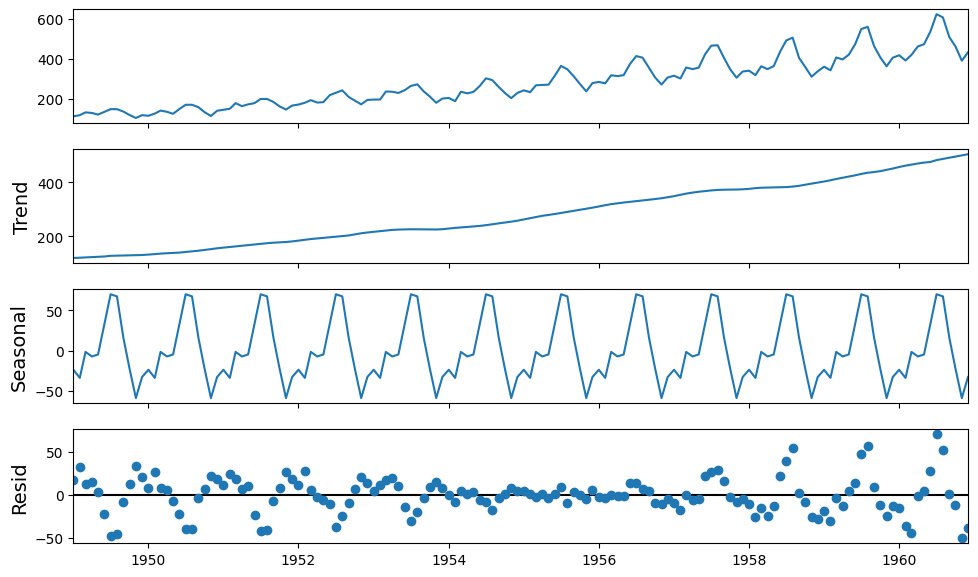

In [170]:
# Additive Decomposition
result_add = seasonal_decompose(df["1949":"1960"], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
result_add.plot();

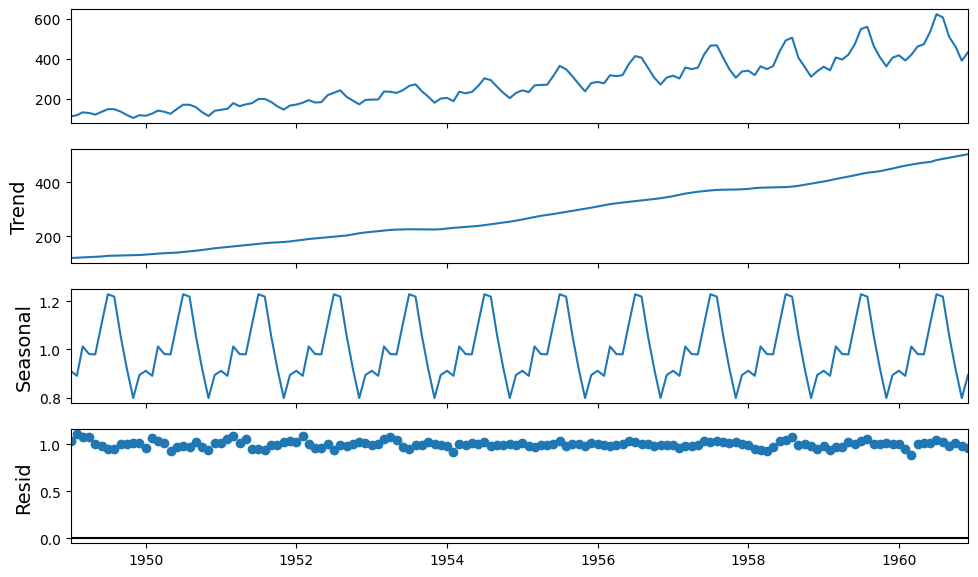

In [171]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df["1949":"1960"], model = 'multiplicative', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
result_mul.plot();

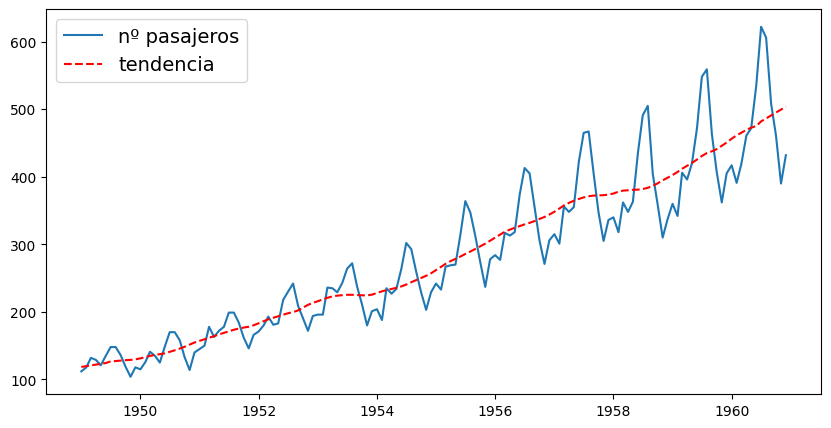

In [172]:
plt.figure(figsize=(10,5))
plt.plot(df, label = "nº pasajeros")
plt.plot(result_add.trend, label="tendencia",color="red", linestyle="dashed")
# df["1949-01-01":"1960-12-01	"].plot(grid=True, marker=".", figsize=(8, 3.5), label = "nº pasajeros")
plt.legend()
plt.show()

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

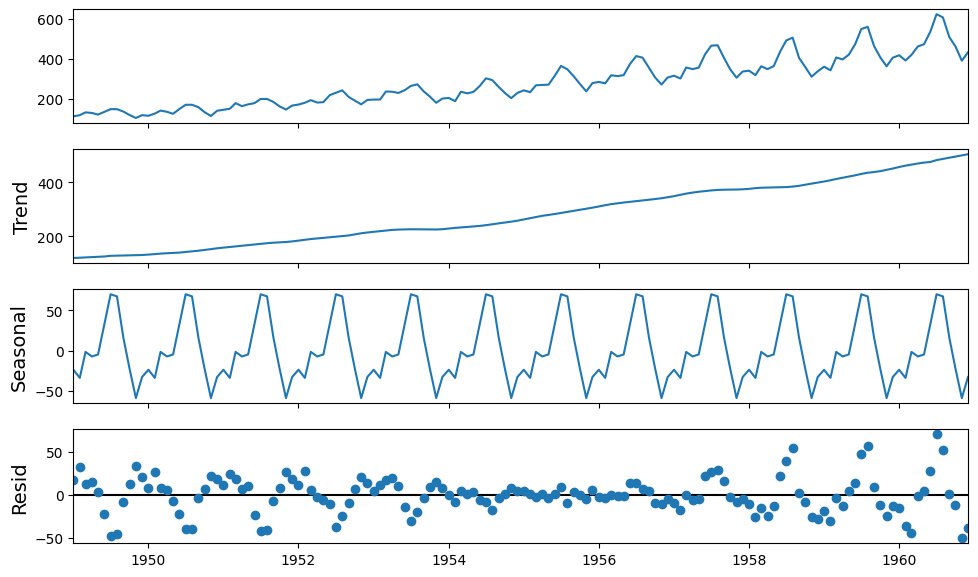

In [173]:
# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
result_add.plot();

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

In [174]:
df_shifted = df.copy()  # Copiamos el DataFrame original

# Verificamos la columna a usar (si hay más de una, tomamos la primera)
col_name = df.columns[0]  # Nombre de la primera columna
df_shifted = df[[col_name]]  # Convertimos a DataFrame para evitar errores de indexado

# Crear las columnas desplazadas (lags de 1 a 24)
for lag in range(1, 25):
    df_shifted[f'lag_{lag}'] = df_shifted[col_name].shift(lag)

# Calcular la matriz de correlación
corr_matrix = df_shifted.corr()


In [175]:
corr_matrix.iloc[:,0]

value     1.000000
lag_1     0.960195
lag_2     0.895675
lag_3     0.837395
lag_4     0.797735
lag_5     0.785943
lag_6     0.783919
lag_7     0.784592
lag_8     0.792215
lag_9     0.827852
lag_10    0.882713
lag_11    0.949702
lag_12    0.990527
lag_13    0.948107
lag_14    0.875448
lag_15    0.811466
lag_16    0.769449
lag_17    0.755819
lag_18    0.748752
lag_19    0.745500
lag_20    0.751789
lag_21    0.794503
lag_22    0.859013
lag_23    0.936717
lag_24    0.983254
Name: value, dtype: float64

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

- Cada 12 instantes (meses)


### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [176]:
X_train = df["1949-01-01":"1959-05-01"] # El train ya lleva su target, el valaor del día (periodo) sigiuente salvo para el último
# X_train = X_train.asfreq('M')  # Si los datos son mensuales


X_test = df["1959-05-01":"1960-12-01"] # 20 muestras para el tests

In [177]:
X_test.shape

(20, 1)

### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [178]:
model_arima = auto_arima(X_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace= True,
                   stepwise = False) 

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1189.463, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1181.469, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1179.396, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1183.616, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1174.062, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1181.987, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=1181.204, Tim

In [191]:
y_pred = model_arima.predict(20) 

In [193]:
y_pred

1959-06-01    426.200489
1959-07-01    408.248135
1959-08-01    421.448645
1959-09-01    409.780537
1959-10-01    421.620985
1959-11-01    424.090351
1959-12-01    425.406269
1960-01-01    431.586955
1960-02-01    428.810728
1960-03-01    434.046204
1960-04-01    434.610315
1960-05-01    437.577708
1960-06-01    440.938554
1960-07-01    442.209762
1960-08-01    445.730227
1960-09-01    447.177356
1960-10-01    449.939579
1960-11-01    452.325230
1960-12-01    454.514438
1961-01-01    457.280776
Freq: MS, dtype: float64

In [194]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(X_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 79.3784


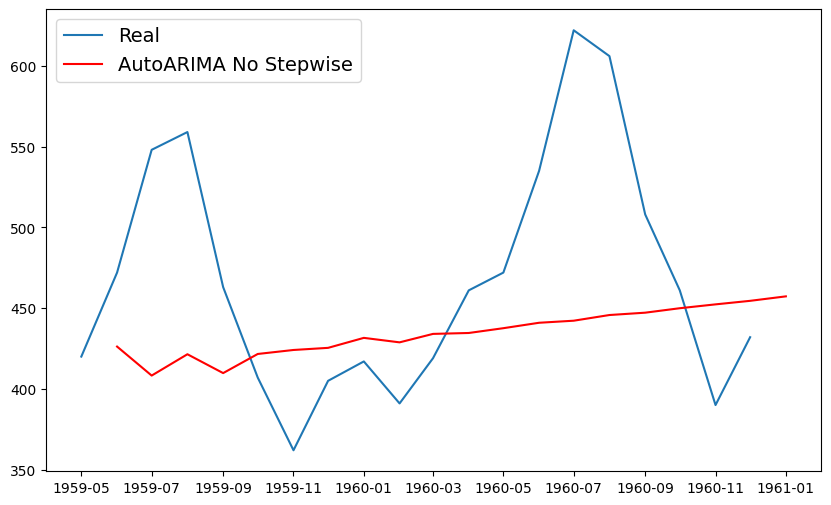

In [195]:
plt.plot(X_test, label = "Real")
plt.plot(y_pred,color='red', label = "AutoARIMA No Stepwise")
plt.legend()

### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [188]:
model_sarima = auto_arima(df,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   m = 12, # periodo estacionalidad 
                #    seasonal= True,
                   trace= True,
                   stepwise = False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1030.752, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1032.276, Time=0.29 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1030.408, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1034.096, Time=0.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1020.639, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1019.494, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1020.327, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1012.991, Time=1.09 sec
 ARIM

In [199]:
# Definir el inicio y fin de la predicción dentro del conjunto de prueba
start_test = len(X_train)  # Índice donde empieza X_test en la serie completa
end_test = start_test + len(X_test) - 1  # Índice donde termina X_test

# Predecir valores dentro del conjunto de prueba
y_pred_sarima = model_sarima.predict_in_sample(start=start_test, end=end_test)

y_pred_sarima

1959-06-01    490.778333
1959-07-01    536.395995
1959-08-01    551.246618
1959-09-01    461.160751
1959-10-01    409.061091
1959-11-01    357.930548
1959-12-01    391.499541
1960-01-01    417.505756
1960-02-01    395.164388
1960-03-01    455.538866
1960-04-01    423.374245
1960-05-01    467.697385
1960-06-01    535.812665
1960-07-01    608.957586
1960-08-01    627.839107
1960-09-01    511.392542
1960-10-01    451.346311
1960-11-01    407.143463
1960-12-01    437.437037
1961-01-01    450.053654
Freq: MS, Name: predicted_mean, dtype: float64

In [200]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(X_test, y_pred_sarima))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 53.3864


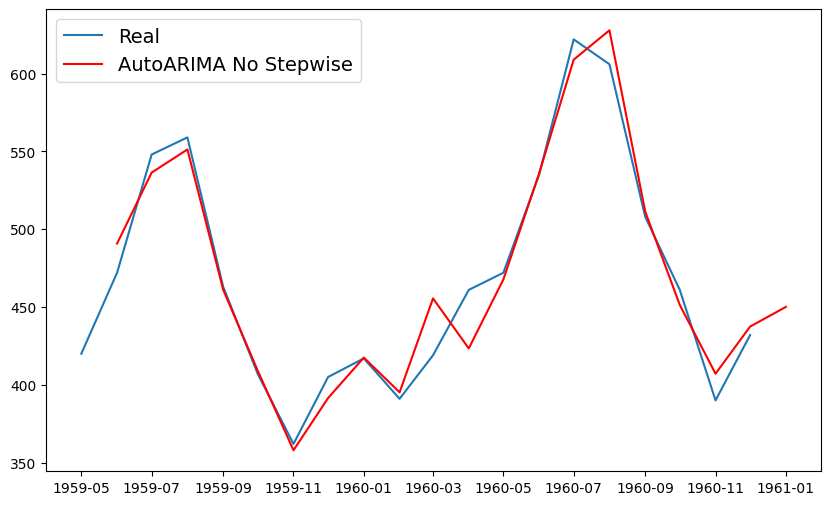

In [201]:
plt.plot(X_test, label = "Real")
plt.plot(y_pred_sarima,color='red', label = "AutoARIMA No Stepwise")
plt.legend()